In [1]:
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import root_conv as rtc
import afterpulse_analyser.kiyomoto_method as ap
import afterpulse_analyser.moduleqc as apm
import multiphe_analyser as mp
import singlephe_analyser as sgph
import pypdf
import math
import os
import math
import csv
import ROOT as RT
import random
import uproot
import subprocess
import time
import sys
import datetime
from scipy.optimize import curve_fit
from art import *

Welcome to JupyROOT 6.26/02


# 概要
- PMTのQuality Checkをするための測定スクリプトを作りたい！
- 測定項目
    - Single Phe測定
        - Gain推定に用いる
        - パルス幅
        - 収集効率
    - Multi Phe測定
        - HV依存性
        - 時間依存性
            - Transit Time
            - Transit Time Spread
        - アフターパルス
    - 管面依存性
        - Multi Phe
            - 光電面にマスクをかける必要有り...

- 測定フローを作成
    1. SinglePheを測定(1400V)
        1. 1p.e.の光量に絞る
        2. 波形取得
    2. MultiPheを測定(1400V)
        1. TBD p.e.の光量に絞る (900Vでも波形が見える程度に)
        2. 波形取得
    3. HVを下げていく
        1. HV変更
        2. 波形取得
    
    4. Afterpulse
        1. HV変更
        2. 波形取得
    

## やること
- 測定と解析をスムーズに行うために、測定系を自動化する
- SinglePheの測定とMultiPheの測定をスムーズにやりたい
    - 光量の推定を自動化できると良いね

- <span style="color: red; ">問題点</span>
    - 残念なことに、HV調整の自動化ができていない...
        - TexioのコントローラーがWindowsじゃないと動かない

# ということで、現状のDAQシステムをうまく利用して、自動光量推定を行う
- # 1p.e.の測定結果を使う

In [11]:
#とりあえず適当なPMTの1p.e.の測定データ
file = "/Users/kiyomoto/reaserch/PMT_data/pmt/230811/AC1971/20230811_AC1971_single.root"

In [12]:
#波形を見てみる
pyfile = "/Users/kiyomoto/git/Script/show_waveform.py"
subprocess.call(["ipython", pyfile, file, "Treesource_0" ,"ori", "50000","fig"])

KeyboardInterrupt: 

]0;IPython: reaserch/231219

In [ ]:
#uprootで概要を作る(実装はROOT C++の予定?)
rtc.tree_name(file)
wf = rtc.get_branch_val(file, "Treesource_0", "wform1") - rtc.get_branch_val(file, "Treesource_0", "wform0")
wf_d = rtc.get_branch_val(file, "Treedark_0", "wform1") - rtc.get_branch_val(file, "Treedark_0", "wform0")

File Name=> /Users/kiyomoto/reaserch/PMT_data/pmt/230811/AC1971/20230811_AC1971_single.root
Name => Treesource_0;16, Type => TTree
Name => Treesource_0;15, Type => TTree
Name => Treedark_0;1, Type => TTree
[[-3.30e+00  6.70e+00 -1.20e+00 ... -3.60e+00 -2.40e+00 -3.00e+00]
 [-2.10e+00  5.50e+00 -2.60e+00 ... -3.20e+00 -3.70e+00 -4.30e+00]
 [-2.50e+00  8.20e+00  6.00e-01 ... -2.00e-01 -8.00e-01 -7.00e-01]
 ...
 [-1.10e+00  7.40e+00 -7.00e-01 ...  4.00e-01  0.00e+00 -1.00e-01]
 [-1.00e+00 -1.21e+02  2.00e-01 ...  9.00e-01  8.00e-01 -1.00e-01]
 [-1.30e+00  8.20e+00  9.00e-01 ...  6.00e-01  1.40e+00  5.00e-01]]
[[-2.60e+00  7.10e+00 -1.40e+00 ... -3.10e+00 -3.20e+00 -3.40e+00]
 [-1.90e+00  5.90e+00 -2.70e+00 ... -2.00e+00 -2.40e+00 -2.30e+00]
 [-1.40e+00  9.20e+00  8.00e-01 ...  1.00e-01  4.00e-01 -1.00e-01]
 ...
 [ 9.00e-01  1.04e+01  1.10e+00 ...  1.80e+00  2.20e+00  1.40e+00]
 [ 0.00e+00 -1.37e+02 -3.00e-01 ...  9.00e-01  8.00e-01  6.00e-01]
 [ 4.00e-01  9.30e+00  8.00e-01 ...  8.00e-01 

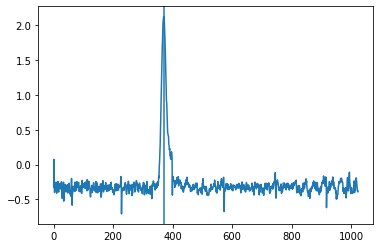

In [ ]:
# まずは、1p.e.のピークを探す
plt.plot(np.average(wf,axis=0))
peak = np.argmax(np.average(wf,axis=0))
plt.axvline(np.argmax(np.average(wf,axis=0)))

In [ ]:
cell_bind = np.max(wf[:,peak-4:peak+4], axis=1)

In [ ]:
cell_bind

array([ 6.7,  6.4,  1.7, ..., -0.6,  0.6,  0.6], dtype=float32)

In [ ]:
single_phe = []
for i in range(len(cell_bind)):
    if cell_bind[i] >= 5.0 and cell_bind[i] < 10.0:
        single_phe.append(i)
print(len(single_phe))
print(len(single_phe)/len(cell_bind))

11380
0.22759544809103818


In [ ]:
10/50

0.2

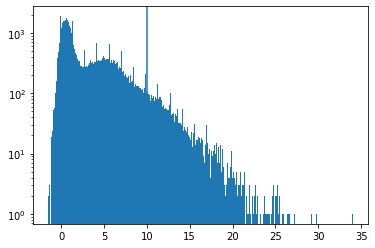

In [ ]:
plt.hist(cell_bind, bins = 330)
plt.axvline(10)
plt.yscale("log")

In [ ]:
def AnaSingleWF(file, Gain = "H",tree_s = "Treesource_0", tree_d = "Treedark_0"):

    #取得するbranch(HGの時は、wform1,0を使用し、LGの時は、wform3,2を使用する)
    #※基本的にSingePhe測定はHGで行う
    if Gain == "H":
        wform_pos = "wform1"
        wform_neg = "wform0"
        #1p.e.のピーク波高値の範囲(7dyPMTの場合 ※あくまで経験から設定)
        thres_min = 5.0
        thres_max = 10.0

    elif Gain == "L":
        wform_pos = "wform3"
        wform_neg = "wform2"
        #1p.e.のピーク波高値の範囲(7dyPMTの場合 ※あくまで経験から設定)
        thres_min = 0.3
        thres_max = 0.6

    #SourceとDarkの差動電圧をとる
    wf = rtc.get_branch_val(file, tree_s, wform_pos) - rtc.get_branch_val(file, tree_s, wform_neg)
    wf_d = rtc.get_branch_val(file, tree_d, wform_pos) - rtc.get_branch_val(file, tree_d,  wform_neg)
    avf_d = np.average(wf_d)        #Darkの平均波形を取り、ベースラインとする

    peak = np.argmax(np.average(wf,axis=0))     #Sourceのピーク位置を取得
    cell_bind = np.max(wf[:,peak-4:peak+4], axis=1)     #各イベントピークの前後4cellだけ取り出し、その波高の最大値を取得


    #各イベントで1p.e.の波高値の範囲に入っているか探査する
    single_phe = []
    for i in range(len(cell_bind)):
        if cell_bind[i] >= thres_min and cell_bind[i] < thres_max:
            single_phe.append(i)
    
    print("1p.e. evnet num => {0} events".format(len(single_phe)))
    print("1p.e. Probability of occurrence => {0} p.e.".format(len(single_phe)/len(cell_bind)))

    return len(single_phe), len(single_phe)/len(cell_bind)
    

In [ ]:
AnaSingleWF(file)

[[-3.30e+00  6.70e+00 -1.20e+00 ... -3.60e+00 -2.40e+00 -3.00e+00]
 [-2.10e+00  5.50e+00 -2.60e+00 ... -3.20e+00 -3.70e+00 -4.30e+00]
 [-2.50e+00  8.20e+00  6.00e-01 ... -2.00e-01 -8.00e-01 -7.00e-01]
 ...
 [-1.10e+00  7.40e+00 -7.00e-01 ...  4.00e-01  0.00e+00 -1.00e-01]
 [-1.00e+00 -1.21e+02  2.00e-01 ...  9.00e-01  8.00e-01 -1.00e-01]
 [-1.30e+00  8.20e+00  9.00e-01 ...  6.00e-01  1.40e+00  5.00e-01]]
[[-2.60e+00  7.10e+00 -1.40e+00 ... -3.10e+00 -3.20e+00 -3.40e+00]
 [-1.90e+00  5.90e+00 -2.70e+00 ... -2.00e+00 -2.40e+00 -2.30e+00]
 [-1.40e+00  9.20e+00  8.00e-01 ...  1.00e-01  4.00e-01 -1.00e-01]
 ...
 [ 9.00e-01  1.04e+01  1.10e+00 ...  1.80e+00  2.20e+00  1.40e+00]
 [ 0.00e+00 -1.37e+02 -3.00e-01 ...  9.00e-01  8.00e-01  6.00e-01]
 [ 4.00e-01  9.30e+00  8.00e-01 ...  8.00e-01  1.60e+00  8.00e-01]]
[[-5.200e+00  4.600e+00 -3.000e+00 ... -2.900e+00 -2.900e+00 -3.300e+00]
 [-1.200e+00 -1.416e+02 -3.400e+00 ... -2.500e+00 -3.200e+00 -2.900e+00]
 [-1.900e+00 -1.406e+02 -8.000e-01 ...

(11380, 0.22759544809103818)

In [ ]:
#DRS4の操作
def RunHageFusaScript(file, tree, eventnum, serial=2386, delay = 60, freq=5.0):
    READDrs4_path = '/Users/cta/Software/JustReadDrs4_Sunada_20210408/ReadDrs4'
    try:
        subprocess.call([READDrs4_path,'-s','{0}'.format(serial),'-i','0','-f','{1}'.format(freq),'-d','{2}'.format(delay),'-e','{3}'.format(eventnum),'-m','{4}'.format(tree),'-n','0','-O','{5}'.format(file)])
    except:
        print("ERROR with DRS4!")

def CalDrs4():
    READDrs4_path = '/Users/cta/Software/JustReadDrs4_Sunada_20210408/ReadDrs4'
    try:
        subprocess.call([READDrs4_path, '-c', 'time', '-f', '5.0'])
    except:
        print("DRS4 Callibration Error!")
    
    try:
        subprocess.call([READDrs4_path, '-c', 'volt', '-f', '5.0'])
    except:
        print("DRS4 Callibration Error!")

    print("Callibration Done!")
    

In [ ]:
#FilterWheelの操作
def ChangeFW(fw_num):
    subprocess.call(['multi-filterwheel', '{0}'.format(fw_num)])
    time.sleep(3)

In [2]:
class PMT_Merin_sys:
    def __init__(self):
        #パラメータの初期化
        self.Anapath = '/Users/kiyomoto/'
        self.SingleLit = 28     #SinglePheのFW光量
        self.MultiLit = 15      #MultiPheのFW光量
        self.APLit = 11      #AfterpulseのFW光量
        self.Treename_s = "source"
        self.Treename_d = "dark"
        self.hv = 1400      #HVの初期値は1400で固定
        self.event_s = 50000    #Sourceイベント数
        self.event_d = 1000     #Darkイベント数

        Art=text2art("PMT")
        print(Art)
        print("~~~ Welcome to PMT measurement System!! (v0.9) ~~~")
        b = False
        while b == False:
            self.pmt_serial = input("Please input PMT serial number?")
            print("Your PMT => {0}".format(self.pmt_serial))
            key = input("IS it OK? (y/n)")
            if key == "y":
                b = True

        self.date = self.GetToday()[1]
        s = 1
        if s == 0:
            self.path = self.CreateDir()

        self.Call()
    
    def Call(self):
        mode = self.ShowMode()
        self.RunMeasurement(mode)

    def RunMeasurement(self, key):
        if key == 1:
            a = 1
            self.Set1PELight()
            self.SinglePheMeasurement()
        elif key == 2:
            a = 2
            self.MultiPheMeasurement()
        elif key == 3:
            a = 3
            print("Function is not READY...")
        elif key == 4:
            a = 4
            self.HVGainMeasurement()
        elif key == 5:
            a = 5
            print("Function is not READY...")
        elif key == 6:
            a = 6
            print("Function is not READY...")
        elif key == 7:
            a = 7
            print("Function is not READY...")
        elif key == 8:
            a = 8
            print("Function is not READY...")
        p = input("Continuing? =>(y/n)")
        if p == "n":
            print("end!!")
        elif p == "y":
            self.Call()

    def ShowMode(self):
        print("##############################")
        print("Which items are measured??")
        print("1. SinglePhe")
        print("2. MultiPhe")
        print("3. Pulse Width")
        print("4. HV-Gain Curve")
        print("5. Transit Time")
        print("6. Transit Time Spread")
        print("7. Afterpulse")
        print("8. Photocathod Dependency")
        print('q. Exit')
        print("##############################")

        key = input("please enter the mode =>(1~9 or q)")
        if key == "q":
            print("End Process")
            #os._exit(os.EX_OK)
            #sys.exit()
        else:
            return key
        
    def GetToday(self):
        t_delta = datetime.timedelta(hours=9)
        JST = datetime.timezone(t_delta, 'JST')
        now = datetime.datetime.now(JST)
        Y = now.strftime('%Y%m%d')
        y = now.strftime('%y%m%d')
        #print(d) 
        return Y, y

    def CreateDir(self, item = ''):
        Y, y = self.GetToday()
        dir_exsist = os.path.exists(self.Anapath+'/{0}/{1}/'.format(y, self.pmt_serial))
        #print(self.Anapath+'/{0}/{1}/'.format(y, self.pmt_serial))
        if dir_exsist == True:
            print("Result Directory is Already Exsists!!")
            key = input("is it OK to continue?(y/n)")
            if key == "n":
                sys.exists()
        else:
            os.makedirs(self.Anapath+'/{0}/{1}/{2}'.format(y, self.pmt_serial, item))

        return self.Anapath+'/{0}/{1}/{2}'.format(y, self.pmt_serial, item)

    def GetPmtSerial(self):
        print("PMT Serial num => {0}".format(self.pmt_serial))
        return self.pmt_serial

    def Getdynodenum(self):
        if self.pmt_serial.startswith("ZQ"):
            dynode_num = 8
            print("PMT Serial => {0} ({1}dynode PMT)".format(self.pmt_serial, dynode_num))
        elif self.pmt_serial.startswith("AA"):
            dynode_num = 7
            print("PMT Serial => {0} ({1}dynode PMT)".format(self.pmt_serial, dynode_num))
        return dynode_num
    
    def SetHV(self):
        print("Setting HV...")
        self.hv = input("Please Check Power Supplyer and Enter HV-val ==> ")

    def Set1PELight(self):

        #光量の調整
        flag = False
        while flag == False:
            ChangeFW(self.SingleLit)
            RunHageFusaScript(self.path+"temp.root", self.Treename_s, 2000)
            ChangeFW(36)
            RunHageFusaScript(self.path+"temp.root", self.Treename_d, self.event_d)
            counts, rate = AnaSingleWF(self.path+"temp.root")
            if rate < 0.2:
                self.SingleLit += 1
            elif rate > 0.5:
                self.SingleLit -= 1
            else:
                flag = True

        #光量調整終了
        print("SinglePhe Lit => {0}".format(self.SingleLit))

    def SinglePheMeasurement(self):
        self.SetHV(self)
        singlepe_path = self.CreateDir(self, item = 'SinglePhe_{0}V'.format(self.hv))
        file_name = self.date + '_' + self.pmt_serial + '_' + 'SinglePhe_{0}V'.format(self.hv) + ".root"

        ChangeFW(self.SingleLit)
        RunHageFusaScript(singlepe_path+file_name, self.Treename_s, self.event_s)
        ChangeFW(36)
        RunHageFusaScript(singlepe_path+file_name, self.Treename_d, self.event_d)

    def MultiPheMeasurement(self):
        self.SetHV(self)
        multipe_path = self.CreateDir(self, item = 'MultiPhe_{0}V'.format(self.hv))
        file_name = self.date + '_' + self.pmt_serial + '_' + 'MultiPhe_{0}V'.format(self.hv) + ".root"

        ChangeFW(self.MultiLit)
        RunHageFusaScript(multipe_path+file_name, self.Treename_s, self.event_s)
        ChangeFW(36)
        RunHageFusaScript(multipe_path+file_name, self.Treename_d, self.event_d)

    def HVGainMeasurement(self):
        multipe_path = self.CreateDir(self, item = 'HVGainCurve')
        for hv in range(1400, 800, -100):
            input('{0}V Measurement Start! Please Check Power Supplyer! Continue?=>(y/n)'.format(hv))
            file_name = self.date + '_' + self.pmt_serial + '_' + 'MultiPhe_{0}V'.format(hv) + ".root"
            ChangeFW(self.MultiLit)
            RunHageFusaScript(multipe_path+file_name, self.Treename_s, self.event_s)
            ChangeFW(36)
            RunHageFusaScript(multipe_path+file_name, self.Treename_d, self.event_d)

            print('{0}V Measurement Done!'.format(hv))
        print("End HV-Gain Measurement")
        
    

In [ ]:
print("/Users/kiyomoto/{0}/{1}".format("pmt", ''))

/Users/kiyomoto/pmt/


In [ ]:
print("/Users/kiyomoto/{0}/".format("pmt"))

/Users/kiyomoto/pmt/


In [3]:
hoge = PMT_Merin_sys()

 ____   __  __  _____ 
|  _ \ |  \/  ||_   _|
| |_) || |\/| |  | |  
|  __/ | |  | |  | |  
|_|    |_|  |_|  |_|  
                      

~~~ Welcome to PMT measurement System!! (v0.9) ~~~
Your PMT => AA2339
##############################
Which items are measured??
1. SinglePhe
2. MultiPhe
3. Pulse Width
4. HV-Gain Curve
5. Transit Time
6. Transit Time Spread
7. Afterpulse
8. Photocathod Dependency
q. Exit
##############################
end!!


In [ ]:
hoge.CreateDir()

/Users/hoge/231220/y/


In [ ]:
hoge.GetPmtSerial()
hoge.Getdynodenum()
hoge.GetToday()

PMT Serial num => ZQ6666
PMT Serial => ZQ6666 (8dynode PMT)
20231220


In [ ]:
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y%m%d')
print(d)  # 20211104173728

20231220


In [ ]:
d.split("20")

['', '2312', '']